# Builiding a Review-Based QA System

## The Dataset

SubjQA dataset, which consists of more then 10,000 customer reviews in English. Products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

Most of the answers are *subjective*, they depend on the personal experience of the users.

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [3]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()} # flatten nested columns

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [5]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


First, the questions are not grammatically correct, which is quite common in FAQ sections.
Second, an empty *answers.text* entry denotes "unanswerable" questions whose answer cannot be found in the review.
Finally, we can use the start index and length of the answer span to slice out the cpan of text in the review that corresponds to the answer.

In [6]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx: end_idx]

'this keyboard is compact'

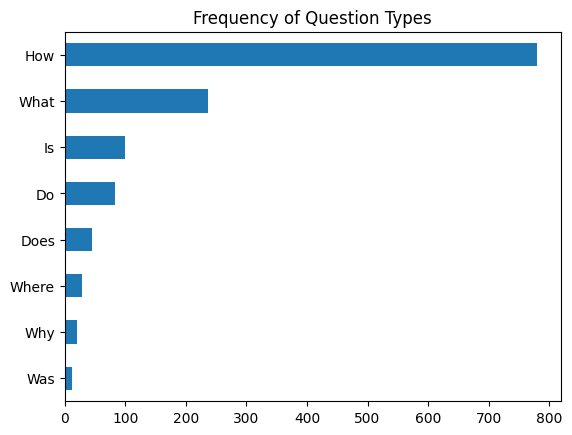

In [7]:
import matplotlib.pyplot as plt
# what types of questions are in the training set
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [8]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']
    ):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Extracting Answers from Text

### Tokenizing text for QA

In [9]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [10]:
question = "How much music can this hold?"
context = """An MP3 is about 1MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [11]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1mb / minute, so about 6000 hours depending on file size. [SEP]


In [12]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-1.1224, -4.7834, -5.3935, -5.2447, -5.2899, -5.4980, -4.9885, -6.1783,
         -1.1224,  0.3651, -0.0807, -1.5551,  3.9556,  4.9206, -2.7833, -3.7461,
         -1.7211, -4.6096, -1.3769,  4.0256,  4.9715, -0.2477, -3.0354, -4.8180,
         -2.2386, -3.4867, -3.5462, -1.1224]]), end_logits=tensor([[-1.0707, -5.4841, -5.0304, -5.1770, -5.4496, -5.5120, -5.2013, -4.6178,
         -1.0707, -3.7223, -0.7583, -3.6969, -2.9205, -1.7346,  0.3122, -2.8688,
          4.8807,  0.2692, -3.1317, -3.2404,  0.8239,  5.6645, -0.2568, -4.8910,
         -3.1677, -0.0130,  1.6739, -1.0707]]), hidden_states=None, attentions=None)


Here we can see that we get a *QuestionAnsweringModelOutput* object as the output of the QA head. The QA head corresponds to a linear layer that takes the hidden states from the encoder and computes the logits for the start and end spans. This means that we treat QA as a form of token classification (similar to NER).
To convert the outputs into an answer span, we first need to get the logits for the start and end tokens:

In [13]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [14]:
# Compute argmax over the start and end token logits and then slice the span of from the inputs
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [15]:
# In Transformers, all of these preprocessing and postprocessing steps are conveniently wrapped in a dedicated pipeline
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:334: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.24360325932502747,
  'start': 37,
  'end': 47,
  'answer': '6000 hours'},
 {'score': 0.2315085083246231,
  'start': 16,
  'end': 47,
  'answer': '1MB/minute, so about 6000 hours'},
 {'score': 0.10571681708097458,
  'start': 16,
  'end': 26,
  'answer': '1MB/minute'}]

In [16]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.8946091532707214, 'start': 0, 'end': 0, 'answer': ''}

In [17]:
# Sliding window
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                             return_overflowing_tokens=True, max_length=100,
                             stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [18]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [19]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



## Using Haystack to Build a QA Pipeline

In reality our system's users will only provide a question about a product, so we need some way of selecting relevant passages from among all the reviews in our corpus.

To handle this, modern QA systems are typically based on the *retriever-reader* architecture:
- Retriever:
  Responsible for retrieving relevant documents for a given query.
  *Sparse* retrievers use word frequencies to represent each document and query as a sparse vector. Inner product of query and document to obtain relevance.
  *Dense* retrievers use encoders like transformers to represent the query and document as contextualized embeddings.
  
- Reader:
  Extracts the answer from the documents provided by the retriever. Reading comprehension model.

- Document store: document-oriented database that stores documents and metadata provided at query time to the retriever

- Pipeline: combines all the components of QA system

### Initializing a document store

In [34]:
url = "https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz"

# Use ! to run shell commands
! wget -nc -q "$url"
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz


In [35]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
# DO NOT run chown in a non-root environment
# !chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT)
# Wait until Elasticsearch has started
import time
time.sleep(30)

In [36]:
# If you want to stop Elasticsearch from Jupyter:
# es_server.terminate()   # or es_server.kill()
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "ura",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "aAbGjspuS66pdTiqAagDRg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [40]:
# Instantiate the document store
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)

ImportError: cannot import name 'send_event' from 'haystack.telemetry' (/home/ssanchez/env/transformers/lib/python3.8/site-packages/haystack/telemetry/__init__.py)